<a href="https://colab.research.google.com/github/dantruonghtno1/MCDNN-for-image-classification/blob/main/MCDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import DataLoader ,random_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from collections import OrderedDict
import time

create function to generate dataset at specific size 

In [2]:
def get_transform(target_size):
    composed = transforms.Compose([transforms.Resize((target_size, target_size)), transforms.ToTensor()])
    

In [3]:
def get_datasets(target_size = 29):
    assert target_size<=29 and target_size%2 ==1
    composed = transforms.Compose([
                                   transforms.Resize((target_size, target_size)),
                                   transforms.Pad((29-target_size)//2),
                                   transforms.ToTensor()])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=composed)
    train_size = (int)(0.8*len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=composed)

    return dict(train= train_dataset, valid = valid_dataset, test = test_dataset)


In [4]:
def show_tensor_image(image):
    plt.imshow(transforms.ToPILImage()(image), cmap='gray');

In [5]:
data = get_datasets(target_size=21)

In [6]:
len(data['train'])

48000

In [7]:
len(data['valid'])

12000

In [8]:
len(data['test'])

10000

In [9]:
x, y = data['test'][0]

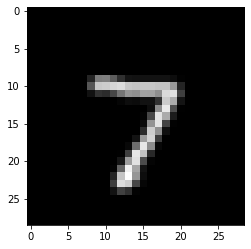

In [10]:
show_tensor_image(x)

In [11]:
x.shape

torch.Size([1, 29, 29])

create model 

In [12]:
class MCDNN(nn.Module):
    def __init__(self):
        super(MCDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=40*3*3, out_features=150),
            nn.ReLU(),
            nn.Linear(in_features=150, out_features=10)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
model = MCDNN()

In [14]:
print(model)

MCDNN(
  (net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=360, out_features=150, bias=True)
    (8): ReLU()
    (9): Linear(in_features=150, out_features=10, bias=True)
  )
)


In [15]:
def initWeight(m):
    if (type(m) == nn.Linear) or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [16]:
lossfunc = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset=data['train'], batch_size=256, shuffle=True, num_workers=6)
valid_loader = DataLoader(dataset=data['valid'], batch_size=128, shuffle=False, num_workers=6)
test_loader = DataLoader(dataset = data['test'], batch_size=32, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
n_epochs = 5
model.apply(initWeight)
def train_model(model, train_loader,valid_loader,lossfunc, optimizer,n_epochs):
    LOSS_train = []
    LOSS_valid = []
    ACC = []
    for epoch in range(n_epochs):
        COST = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = lossfunc(yhat, y)
            loss.backward()
            optimizer.step()
            COST+=loss 
        LOSS_train.append(COST)

        correct = 0
        COST_valid = 0
        for x_test, y_test in valid_loader:
            z = model(x_test)
            COST_valid+= lossfunc(z, y_test)
            _,yhat = torch.max(z.data, 1)
            correct+=(yhat==y_test).sum().item()
        accuracy = correct/len(data['valid'])
        ACC.append(accuracy)
        LOSS_valid.append(COST_valid)

    return LOSS_train, LOSS_valid, ACC

In [18]:
LOSS_train, LOSS_valid, ACC = train_model(model, train_loader,valid_loader,lossfunc, optimizer,n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
print(LOSS_train)

[tensor(84.3016, grad_fn=<AddBackward0>), tensor(19.3551, grad_fn=<AddBackward0>), tensor(14.1332, grad_fn=<AddBackward0>), tensor(11.3101, grad_fn=<AddBackward0>), tensor(9.2219, grad_fn=<AddBackward0>)]


In [20]:
print(ACC)

[0.956, 0.96825, 0.9743333333333334, 0.9793333333333333, 0.9821666666666666]


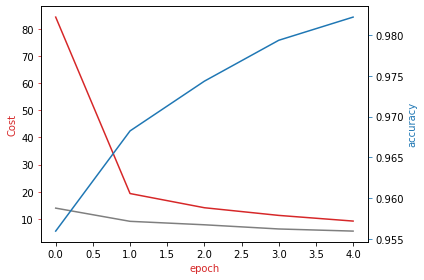

In [21]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
color1 = 'tab:gray'
ax1.plot(LOSS_train, color=color)
ax1.plot(LOSS_valid, color=color1)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( ACC, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

plt.show()

In [22]:
test_error = [(1 - x)*100 for x in ACC]

In [23]:
test_error

[4.400000000000004,
 3.1749999999999945,
 2.5666666666666615,
 2.066666666666672,
 1.7833333333333368]

train all models and save the best models 

In [24]:
TARGET_SIZE = [29, 27, 25, 21, 29,27, 15]

In [25]:
t = 10
t1 = 20
t2 = 30
d = dict(t1 = 1, t2 = 2, t3 = 3)
d

{'t1': 1, 't2': 2, 't3': 3}

In [26]:
d = dict()
for t in TARGET_SIZE:
    d[t] = []
    for j in range(5):
        d[t].append(j)

d[15]
d[29]

[0, 1, 2, 3, 4]

In [ ]:
LOSS_TRAIN = dict()
LOSS_VALID = dict()
ACCURACY = dict()
for target_size in TARGET_SIZE:
    #initial loss_train, loss_valid, accuracy
    LOSS_TRAIN[target_size] = []
    LOSS_VALID[target_size] = []
    ACCURACY[target_size] = []
    for column in range(5):
        model = MCDNN()
        model.apply(initWeight)
        data = get_datasets(target_size)
        lossfunc = nn.CrossEntropyLoss()
        learning_rate = 1e-3
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        train_loader = DataLoader(dataset=data['train'], batch_size=256, shuffle=True)
        valid_loader = DataLoader(dataset=data['valid'], batch_size=128, shuffle=False)
        # test_loader = DataLoader(dataset = data['test'], batch_size=32, shuffle=False, num_workers=6)
        epochs = 5
        #train model where epochs = 5
        LOSS_train, LOSS_valid, ACC = train_model(model, train_loader,valid_loader,lossfunc, optimizer,n_epochs)
        # append model to dict index target_size
        LOSS_TRAIN[target_size].append(LOSS_train)
        LOSS_VALID[target_size].append(LOSS_valid)
        ACCURACY[target_size].append(ACC)
